In [1]:
import pandas as pd
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

SELECT_YEAR = 2017

DATA_PATH = './data'
PLOT_PATH = './docs/plots/{}'.format(SELECT_YEAR)

In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(10)

CPU times: user 93.9 ms, sys: 5.76 ms, total: 99.7 ms
Wall time: 104 ms
(8652, 4) docs shape


,id,titulo,clean,w_count
0,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",9
1,104124422364023,A gold-standard social media corpus for urban ...,"[gold, standard, social, media, corpus, urban,...",8
2,104124422364023,A Framework for Spatial Analytics using Hetero...,"[framework, spatial, analyt, use, heterogen, d...",9
3,105670521813027,Gene expression analysis in Musa acuminata dur...,"[gene, express, analysi, musa, acuminata, comp...",12
4,105670521813027,Mitogenome sequence accuracy using different e...,"[mitogenom, sequenc, accuraci, use, differ, el...",7
5,109837868064895,A study of equivalent electrical circuit fitti...,"[studi, equival, electr, circuit, fit, electro...",14
6,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,"[dynam, connect, vessel, runaway, reaction, ri...",14
7,116792663386170,VLE BASED DYNAMIC SIMULATION OF A TRICKLE-BED ...,"[vle, base, dynam, simul, trickl, bed, reactor...",13
8,116792663386170,SOLUBILITY BEHAVIOR OF GAMMA-VALEROLACTONE + N...,"[solubl, behavior, gamma, valerolacton, tetrad...",9
9,116792663386170,Removal of amoxicillin from water by adsorptio...,"[remov, amoxicillin, water, adsorpt, onto, act...",25


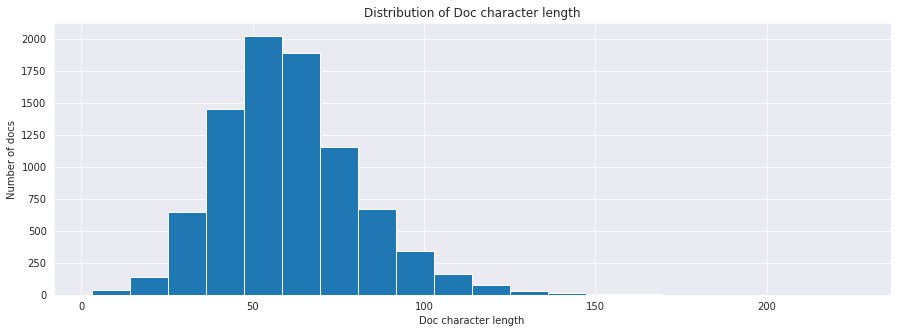

In [3]:
df['clean'] = df['clean'].apply(lambda x: ' '.join(x))

fig = plt.figure(figsize=(15, 5))

doc_lens = [len(d) for d in df.clean]

plt.hist(doc_lens, bins = 20)
plt.title('Distribution of Doc character length')
plt.ylabel('Number of docs')
plt.xlabel('Doc character length')
plt.show()

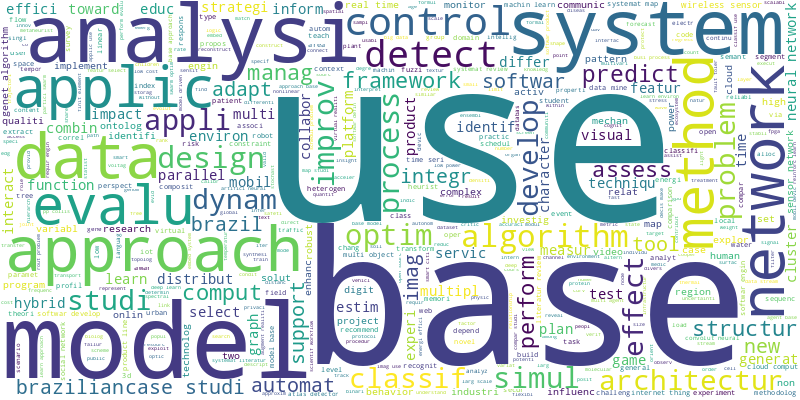

In [4]:
long_string = ' '.join(list(df['clean'].values))

wordcloud = WordCloud(
                width=800, 
                height=400,
                background_color="white",
                max_words=5000,
                contour_width=3,
                contour_color='steelblue'
                ).generate(long_string)

wordcloud.to_image()

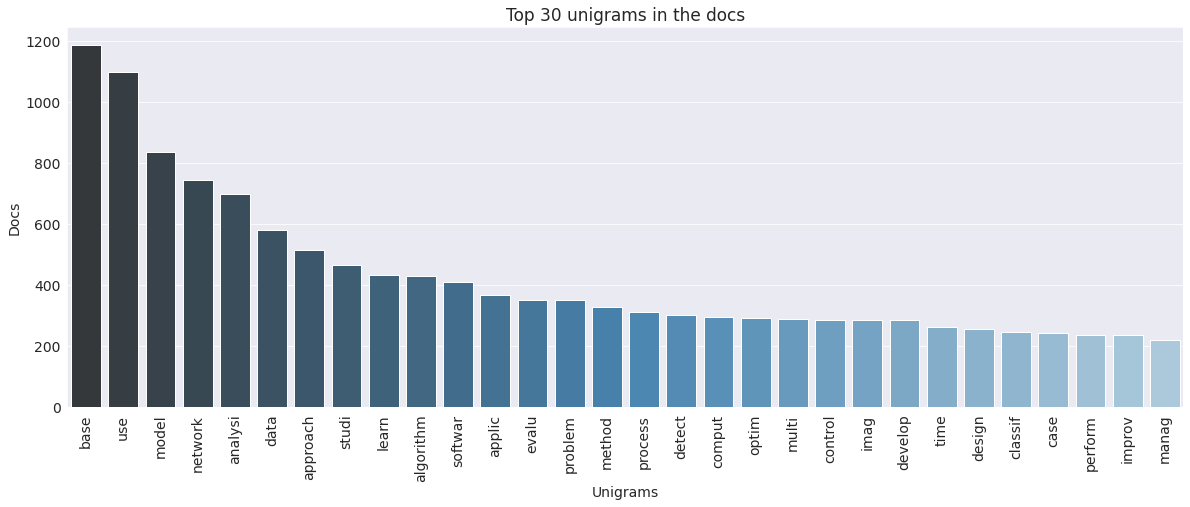

In [5]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['clean'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = plt.figure(figsize=(20,7))

x = df2['unigram']
y = df2['count']

g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='Blues_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=90,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Unigrams', fontsize=14)
plt.ylabel('Docs', fontsize=14)
plt.title('Top 30 unigrams in the docs', fontsize=17)

plt.show()
del df2

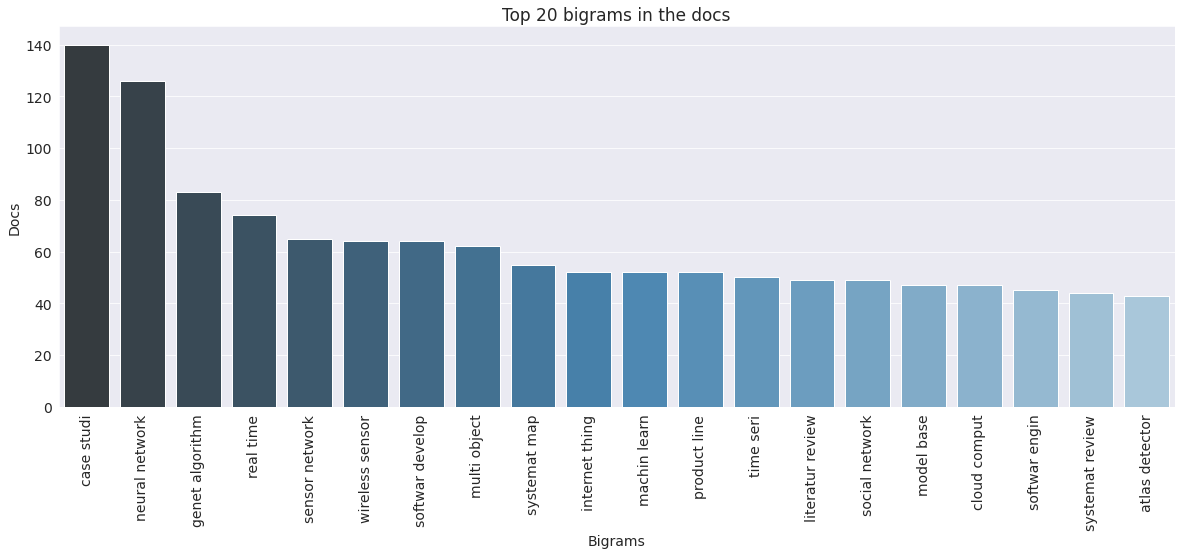

In [6]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['clean'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = plt.figure(figsize=(20,7))

x = df3['bigram']
y = df3['count']

g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='Blues_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=90,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Bigrams', fontsize=14)
plt.ylabel('Docs', fontsize=14)
plt.title('Top 20 bigrams in the docs', fontsize=17)

plt.show()
del df3

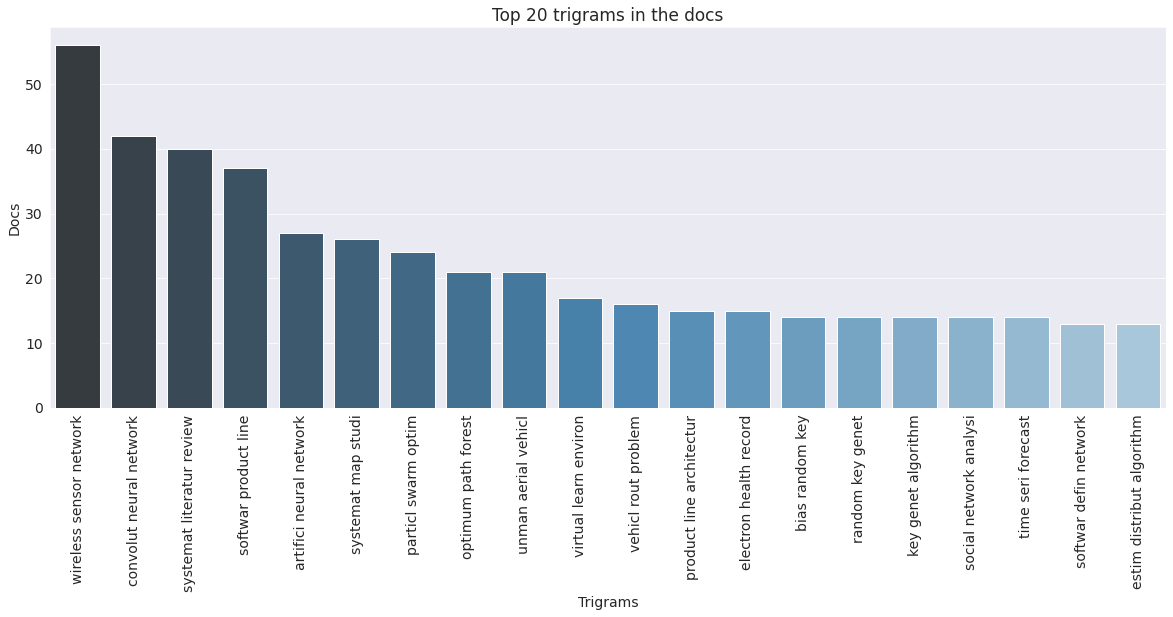

In [7]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['clean'], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = plt.figure(figsize=(20,7))

x = df4['trigram']
y = df4['count']

g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='Blues_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=90,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Trigrams', fontsize=14)
plt.ylabel('Docs', fontsize=14)
plt.title('Top 20 trigrams in the docs', fontsize=17)

plt.show()
del df4

In [8]:
vectorizer = CountVectorizer(
    analyzer='word',
    min_df=3,
    stop_words='english',
    lowercase=True,
    token_pattern='[a-zA-Z0-9]{3,}',
    max_features=5000)

data_vectorized = vectorizer.fit_transform(df['clean'])

lda_model = LatentDirichletAllocation(
    n_components=20, # Number of topics
    learning_method='online',
    random_state=0,
    n_jobs = -1) # Use all available CPUs

lda_output = lda_model.fit_transform(data_vectorized)

In [9]:
ldavis = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(ldavis, 'LDA-modeling.html')
pyLDAvis.display(ldavis)

In [10]:
# print log-likelihood
print("Log likelihood: ", lda_model.score(data_vectorized))

# print perplexity
print("Perplexity: ", lda_model.perplexity(data_vectorized))

Log likelihood:  -508245.4894076752
Perplexity:  2094.4453768508793


In [11]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['W'+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['T'+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19
T0,brazil,architectur,impact,complex,servic,environ,collabor,manag,integr,digit,chang,water,autonom,analysi,field,emerg,virtual,cognit,logic,propos
T1,low,virtual,game,knowledg,cost,recommend,heterogen,user,detector,natur,condit,induc,error,realiti,configur,studi,reason,critic,radiat,stress
T2,model,base,assess,effect,predict,network,qualiti,industri,orient,analysi,deep,solut,program,environ,internet,alloc,develop,control,transform,gene
T3,process,evalu,engin,review,distribut,base,learn,educ,use,systemat,studi,approach,linear,platform,requir,languag,manag,health,monitor,design
T4,dynam,measur,machin,base,featur,select,code,theori,build,robust,similar,tempor,memori,properti,connect,gpu,determin,direct,exploit,locat
T5,map,techniqu,plan,combin,segment,dimension,fault,urban,diagnosi,traffic,risk,topolog,toler,fast,systemat,free,descript,usabl,storag,lesion
T6,applic,analysi,graph,hybrid,use,awar,support,estim,compar,context,adapt,search,mobil,investig,devic,model,autom,forecast,respons,web
T7,data,simul,network,use,sensor,framework,model,activ,open,wireless,experiment,stream,sourc,survey,project,relat,analyt,defin,uncertainti,evolut
T8,studi,case,automat,strategi,identif,tool,heurist,behavior,novel,brazilian,challeng,differ,evalu,signal,communiti,ecosystem,method,public,binari,descriptor
T9,multi,detect,object,inform,base,agent,genom,sequenc,communic,event,type,depend,differ,aspect,hierarch,target,cancer,frequenc,execut,face
